In [ ]:
# prompt: google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



✅ Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84655
           1       1.00      1.00      1.00     18982

    accuracy                           1.00    103637
   macro avg       1.00      1.00      1.00    103637
weighted avg       1.00      1.00      1.00    103637



,precision,recall,f1-score,support
0,1.0,1.0,1.0,84655.0
1,1.0,1.0,1.0,18982.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,103637.0
weighted avg,1.0,1.0,1.0,103637.0


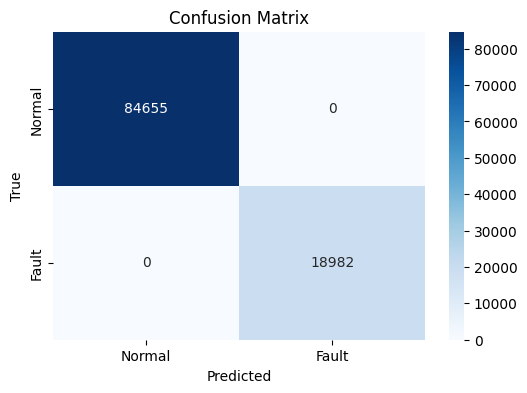

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the label file
label_df = pd.read_csv('/content/drive/MyDrive/Washing_Machine/stream_labels.csv')
label_df = label_df[['timestamp_begin', 'timestamp_end', 'device_id', 'failure']]

# Directory with uploaded CSVs
data_dir = '/content/drive/MyDrive/Washing_Machine'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and 'stream_labels' not in f]

# Read and combine the files
combined_data = []

for file in csv_files:
    try:
        parts = file.replace('.csv', '').split('_')
        device_id = int(parts[0])
        timestamp_begin = int(parts[1])
        timestamp_end = int(parts[2])

        df = pd.read_csv(os.path.join(data_dir, file))
        if 'ActP' in df.columns:
            df['device_id'] = device_id
            df['timestamp_begin'] = timestamp_begin
            df['timestamp_end'] = timestamp_end
            df['source_file'] = file
            combined_data.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine into one DataFrame
full_df = pd.concat(combined_data, ignore_index=True)

# Merge with labels
merged_df = pd.merge(full_df, label_df, on=['timestamp_begin', 'timestamp_end', 'device_id'], how='inner')

# Encode label: 0 = Working, 1 = Fault
merged_df['label'] = merged_df['failure'].apply(lambda x: 0 if str(x).strip().lower() == 'working' else 1)

# Prepare data
X = merged_df.drop(columns=['Ts', 'source_file', 'failure', 'label'], errors='ignore')
y = merged_df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

# Classification Report
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Display as table
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
from IPython.display import display
display(report_df)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install m2cgen


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 7.2 MB/s eta 0:00:00


In [ ]:
# Step 1: Install m2cgen (if not installed yet)
!pip install -q m2cgen

# Step 2: Import m2cgen
import m2cgen as m2c

# Step 3: Generate C code for your trained RandomForest model
c_code = m2c.export_to_c(model)

# Step 4: Save the generated C code into your Washing_Machine folder in Drive
output_path = "/content/drive/MyDrive/Washing_Machine/random_forest_model.c"

with open(output_path, "w") as f:
    f.write(c_code)

print(f"✅ C code generated and saved to: {output_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 2.3 MB/s eta 0:00:00
✅ C code generated and saved to: /content/drive/MyDrive/Washing_Machine/random_forest_model.c


Awesome! You’ve now successfully exported your trained Random Forest model to C code and saved it. Since you’re planning to use it with an STM32H series Nucleo board, the next steps are about integrating this code into your embedded environment. Here’s what you can do next:

✅ Step 5: Prepare STM32CubeIDE or STM32CubeMX project
Create a New STM32 Project
Open STM32CubeIDE
Select your Nucleo-H series board (e.g., NUCLEO-H743ZI2)
Name your project (e.g., RandomForest_Washer)
Set Up Your Project Settings
Set clock configuration and peripherals if needed (e.g., UART for communication, GPIO for input/output)
Generate the basic project files
✅ Step 6: Integrate the Generated C Code
Create a new .c and .h file inside Core/Src and Core/Inc
Copy the contents of random_forest_model.c into the new .c file (e.g., random_forest_model.c)
If m2c.export_to_c() also provided a header file, add that to Core/Inc/
Include the model in main.c or wherever needed:

In [ ]:
#include "random_forest_model.h"

void your_function() {
    float input_features[NUM_FEATURES] = { ... };  // Your sensor inputs
    int result = random_forest_predict(input_features);
    // Take action based on result
}


✅ Step 7: Compile and Flash to Board
Build the project in STM32CubeIDE
Flash it to your Nucleo board
Use UART/USART to send inputs and get predictions or trigger washing machine functions.
✅ Step 8: Test with Real Inputs
Feed real sensor data (e.g., water level, load size) to the input array
Check if the model is making expected predictions
Fine-tune and optimize the code if required